# Lecture - 2: Training a Classifier from Scratch

In [21]:
# Install required libraries (only required if you are using on local machine. Environment like Google Colab have these pre-installed). To use in a Jupyter notebook, uncomment the line below.
# !pip install datasets torch torchvision matplotlib -q

## 1. Data Loading and Preprocessing

In [22]:
from datasets import load_dataset

In [3]:
# Load your dataset from the Hugging Face Hub
hf_repo_id = "preetsojitra/binary-2K-samples-skin-lesion-HM10000" 
dataset = load_dataset(hf_repo_id)

data/train-00000-of-00002.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/278M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/420M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1511 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['lesion_id', 'image', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['lesion_id', 'image', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset', 'label'],
        num_rows: 1511
    })
})

In [5]:
train_ds = dataset['train']
print(train_ds)

Dataset({
    features: ['lesion_id', 'image', 'dx', 'dx_type', 'age', 'sex', 'localization', 'dataset', 'label'],
    num_rows: 2000
})


In [6]:
train_ds[0]

{'lesion_id': 'HAM_0004422',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'dx': 'benign',
 'dx_type': 'histo',
 'age': 70.0,
 'sex': 'female',
 'localization': 'upper extremity',
 'dataset': 'rosendahl',
 'label': 'benign'}

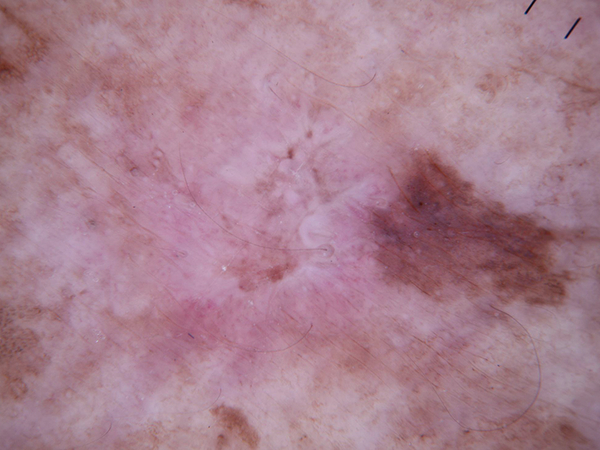

In [7]:
train_ds[0]["image"]

### Image Tranformations

- All images must be the same size for the model to process them in batches. 
- We also need to convert them to PyTorch Tensors and normalize them.
- Normalizing with mean and std of (0.5, 0.5, 0.5) scales the pixel values from [0, 1] to [-1, 1].
- This helps the model train more stably.

Why we need to normalize images using mean as 0.5 and std as 0.5? 

The reason is that pixel values in images typically range from 0 to 255. When we convert these pixel values to a range of [0, 1] by dividing by 255, the mean of the pixel values tends to be around 0.5 for many natural images. By normalizing with a mean of 0.5 and a standard deviation of 0.5, we effectively center the pixel values around 0 and scale them to fall within the range of [-1, 1]. This normalization helps improve the convergence and stability of the training process for neural networks.


In [23]:
from torchvision import transforms

In [24]:
IMG_SIZE = 128 # A smaller size like 128x128 will speed up training significantly. You can use larger sizes like 224x224 for better results if you have the compute power.

data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

## 2. Pytorch Dataset and DataLoader

A pytorch Dataset is a custom class that allows us to load and preprocess our data efficiently. It defines how to access individual data samples and their corresponding labels. It typically implements two main methods: 
1. `__len__` to return the total number of samples in the dataset, and 
2. `__getitem__` to retrieve a specific sample and its label based on an index. 

This class is essential for organizing and managing data in a way that can be easily fed into a PyTorch DataLoader for batching and shuffling during training.

It's like our data loader will call the `__getitem__` method to get a sample and its label whenever it needs to create a batch for training or evaluation.

In [27]:
import torch
from torch.utils.data import Dataset

In [28]:
class SkinLesionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
        # Create a mapping from string labels to integer indices
        self.label_map = {"benign": 0, "malignant": 1}

    def __len__(self):
        # This should return the total number of samples in the dataset.
        return len(self.dataset)

    def __getitem__(self, idx):
        # This method is responsible for getting a single sample and its label.
        item = self.dataset[idx]
        
        # Get the image and apply transformations
        image = item['image']
        if self.transform:
            image = self.transform(image) # this will call our defined transformations that we defined earlier
        
        # Get the label and convert it to an integer
        label_str = item['label']
        label_int = self.label_map[label_str]
        
        # PyTorch loss functions expect labels to be Tensors as well and it should be of type Long for classification tasks
        label = torch.tensor(label_int, dtype=torch.long)
        
        return image, label

In [29]:
# Create instances of our custom dataset for both training and testing
train_pytorch_ds = SkinLesionDataset(dataset['train'], transform=data_transforms)
test_pytorch_ds = SkinLesionDataset(dataset['test'], transform=data_transforms)

print(f"Number of training samples: {len(train_pytorch_ds)}")
print(f"Number of testing samples: {len(test_pytorch_ds)}")

# Let's check a sample to see if it works
img, label = train_pytorch_ds[0]
print(f"\nSample check:")
print(f"Image shape: {img.shape}") # Should be [3, IMG_SIZE, IMG_SIZE]
print(f"Label: {label}")           # Should be 0 or 1

Number of training samples: 2000
Number of testing samples: 1511

Sample check:
Image shape: torch.Size([3, 128, 128])
Label: 0


### DataLoader

In [31]:
from torch.utils.data import DataLoader

In [32]:
BATCH_SIZE = 32 # Number of samples to process in each step. You can adjust this based on your GPU memory. The larger the batch size, the faster the training (up to a point) but it also requires more memory.

train_loader = DataLoader(train_pytorch_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_pytorch_ds, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data.

# Let's inspect a single batch to see its shape
images, labels = next(iter(train_loader))
print(f"\nA single batch:")
print(f"Images batch shape: {images.shape}") # [BATCH_SIZE, Channels, Height, Width]
print(f"Labels batch shape: {labels.shape}") # [BATCH_SIZE]


A single batch:
Images batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


## 3. Model Architecture

In [33]:
import torch.nn as nn

Alright, so there are few things that we need to abide by while building custom model.
1. Our custom model class should inherit from `nn.Module`.
2. We need to define the layers of the model in the `__init__` method.
3. We need to define the forward pass of the model in the `forward` method.

All this is already mentioned clearly in the docs as well.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # --- Convolutional Blocks ---
        # A conv block learns features from the image.
        self.conv_block1 = nn.Sequential(
            # Input: 3 channels (RGB), Output: 16 feature maps
            # Kernel size 3x3 is standard. Padding=1 keeps the image size the same.
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), # output: 16x128x128
            nn.ReLU(), # Activation function to introduce non-linearity
            nn.MaxPool2d(kernel_size=2, stride=2) # Downsamples the image by a factor of 2
        )
        
        self.conv_block2 = nn.Sequential(
            # Input: 16 channels from the previous block, Output: 32 feature maps
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # --- Classifier Head ---
        # This part takes the learned features and makes a final prediction.
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flattens the 32x32x32 feature map into a single vector
            # The input features dimension calculation:
            # Our image starts at 128x128.
            # After first MaxPool: 128/2 = 64x64
            # After second MaxPool: 64/2 = 32x32
            # The number of channels from conv_block2 is 32.
            # So, the flattened size is 32 * 32 * 32.
            # we only need to do the math here for the first Linear layer.
            nn.Linear(in_features=32 * 32 * 32, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes) # Output layer has 2 neurons for our 2 classes
        )

    def forward(self, x):
        # This defines the forward pass: how data flows through the layers.
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

In [35]:
# Set up the device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create an instance of the model and move it to the device
model = SimpleCNN(num_classes=2).to(device)

# Print the model summary
print(model)

SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [38]:
# get the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

# calculate the model size in MB
model_size_MB = num_params * 4 / (1024 ** 2)
print(f"Model size: {model_size_MB:.2f} MB")

Number of trainable parameters: 4199778
Model size: 16.02 MB


## 4. Model Training

In [39]:
loss_fn = nn.CrossEntropyLoss() # Best for multi-class/binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam is a great default optimizer

In [ ]:
NUM_EPOCHS = 5 # Use more epochs for better results

# Lists to track losses for plotting
train_losses = []
batch_losses = []

for epoch in range(NUM_EPOCHS):
    model.train() # Put the model in training mode
    running_loss = 0.0
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Track progress through batches
    total_batches = len(train_loader)
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward pass
        outputs = model(images)
        
        # 2. Calculate loss
        loss = loss_fn(outputs, labels)
        
        # 3. Zero the gradients
        optimizer.zero_grad()
        
        # 4. Backward pass
        loss.backward()
        
        # 5. Update weights
        optimizer.step()
        
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            avg_loss_so_far = running_loss / (batch_idx + 1)
            print(f"  Batch [{batch_idx+1}/{total_batches}] | Loss: {loss.item():.4f} | Avg Loss: {avg_loss_so_far:.4f}")
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"\nEpoch {epoch+1} Summary | Average Training Loss: {avg_train_loss:.4f}")

print("\nFinished Training!")

Epoch 1/5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 | Training Loss: 0.6303


Epoch 2/5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 | Training Loss: 0.5293


Epoch 3/5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3 | Training Loss: 0.4746


Epoch 4/5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4 | Training Loss: 0.4558


Epoch 5/5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 | Training Loss: 0.4481

Finished Training!


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)

# Plot batch-wise loss (shows more detail)
plt.subplot(1, 2, 2)
plt.plot(batch_losses, alpha=0.6)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Model Evaluation

In [ ]:
model.eval() # Put the model in evaluation mode (important!)
correct_predictions = 0
total_samples = 0

total_batches = len(test_loader)

with torch.no_grad(): # We don't need to calculate gradients during evaluation
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        
        # The output is logits. We get the predicted class by finding the index of the max logit.
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Print progress every 10 batches (adjust as needed)
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            current_accuracy = (correct_predictions / total_samples) * 100
            print(f"  Batch [{batch_idx+1}/{total_batches}] | Samples: {total_samples} | Current Accuracy: {current_accuracy:.2f}%")

accuracy = (correct_predictions / total_samples) * 100
print("\n" + "=" * 50)
print(f"Final Model Accuracy on Test Set: {accuracy:.2f}%")
print(f"Correct Predictions: {correct_predictions}/{total_samples}")
print("=" * 50)

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


Model Accuracy on Test Set: 57.64%


## 5. Model Saving

In [ ]:
# --- Save the Model's State Dictionary ---
MODEL_SAVE_PATH = "simple_cnn_skin_lesion.pt"
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\nModel saved to {MODEL_SAVE_PATH}")